In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn as nn
from torchvision import transforms

In [2]:
batch_size = 100
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
transform = transforms.Compose([
  transforms.ToTensor(),
  transforms.Normalize((0.5,),(0.5,))
])

In [4]:
mnist = torchvision.datasets.MNIST(root='datasets/',
                    train=True,
                    transform=transform,
                    download=True)

Extracting datasets/MNIST/raw/train-images-idx3-ubyte.gz to datasets/MNIST/raw


Extracting datasets/MNIST/raw/train-labels-idx1-ubyte.gz to datasets/MNIST/raw



Extracting datasets/MNIST/raw/t10k-images-idx3-ubyte.gz to datasets/MNIST/raw


Extracting datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz to datasets/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [5]:
dataloader = torch.utils.data.DataLoader(dataset=mnist,
                                         batch_size=batch_size,
                                         shuffle=True)


In [6]:
images, labels = iter(dataloader).next()

In [7]:
img = torchvision.utils.make_grid(images)

In [8]:
img = img.detach().numpy()
img = img.clip(0,1)

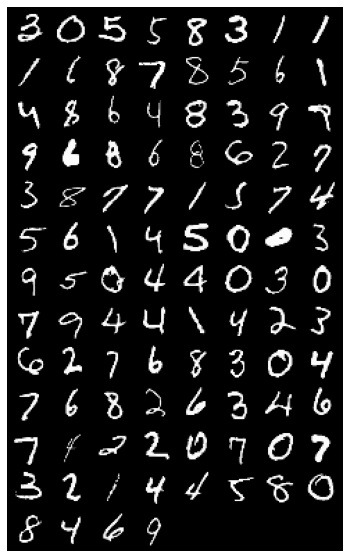

In [9]:
plt.figure(figsize=(12,10))
plt.imshow(np.transpose(img,(1,2,0)))
plt.axis('off')
plt.show()

In [10]:
latent_size = 64
hidden_size= 256
image_size=784
num_epochs = 100

In [11]:
#discriminator model
D= nn.Sequential(
    nn.Linear(image_size,hidden_size),
    nn.LeakyReLU(.2),
    nn.Dropout(.5),
    nn.Linear(hidden_size,hidden_size),
    nn.LeakyReLU(.2),
    nn.Dropout(.5),
    nn.Linear(hidden_size,1),
    nn.Sigmoid()
)

In [12]:
G=nn.Sequential(
    nn.Linear(latent_size,hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size,hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size,image_size),
    nn.Tanh()#needed to map the values to -1 to 1 as done in the original dataset 
)

In [13]:
G=G.to(device)
D=D.to(device)

In [14]:
bce_loss=nn.BCELoss()#measures the error between two probability distribution

d_optimizer = torch.optim.Adam(D.parameters(),lr = 0.0002)
g_optimizer = torch.optim.Adam(G.parameters(),lr = 0.0002)


In [15]:
total_step = len(dataloader)

In [16]:
for epoch in range(num_epochs):
  for i,(images,_) in enumerate(dataloader):
    images = images.reshape(batch_size,-1).to(device)

    real_labels=torch.ones(batch_size,1).to(device)
    fake_labels = torch.zeros(batch_size,1).to(device)
    outputs = D(images)

    d_loss_real = bce_loss(outputs,real_labels)
    real_score = outputs

    z = torch.randn(batch_size,latent_size).to(device)
    fake_images =G(z)

    outputs=D(fake_images)

    d_loss_fake = bce_loss(outputs,fake_labels)
    fake_score = outputs

    d_loss = d_loss_fake + d_loss_real
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

    d_loss.backward()
    d_optimizer.step()
    
    z = torch.randn(batch_size,latent_size).to(device)
    fake_images =G(z)

    outputs=D(fake_images)
    g_loss = bce_loss(outputs, real_labels)
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()
    g_loss.backward()    
    g_optimizer.step()

    if (i+1)%200 ==0:
      print('epoch [{}/{} ], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x):{:.2f},D(G(z)) : {:.2f} '.format(epoch,num_epochs,i+1,total_step,d_loss.item(),
                                                                                                                 g_loss.item(),real_score.mean().item(),fake_score.mean().item()))
    fake_images = fake_images.reshape(fake_images.size(0),1,28,28)

epoch [0/100 ], Step [200/600], d_loss: 0.1185, g_loss: 4.5495, D(x):0.96,D(G(z)) : 0.07 
epoch [0/100 ], Step [400/600], d_loss: 0.2610, g_loss: 3.6513, D(x):0.91,D(G(z)) : 0.12 
epoch [0/100 ], Step [600/600], d_loss: 0.3600, g_loss: 3.3065, D(x):0.84,D(G(z)) : 0.12 
epoch [1/100 ], Step [200/600], d_loss: 0.6043, g_loss: 1.9445, D(x):0.79,D(G(z)) : 0.24 
epoch [1/100 ], Step [400/600], d_loss: 0.9657, g_loss: 1.4744, D(x):0.71,D(G(z)) : 0.36 
epoch [1/100 ], Step [600/600], d_loss: 1.1898, g_loss: 1.2296, D(x):0.66,D(G(z)) : 0.43 
epoch [2/100 ], Step [200/600], d_loss: 0.5972, g_loss: 2.2595, D(x):0.81,D(G(z)) : 0.24 
epoch [2/100 ], Step [400/600], d_loss: 0.6754, g_loss: 2.5018, D(x):0.79,D(G(z)) : 0.24 
epoch [2/100 ], Step [600/600], d_loss: 0.3348, g_loss: 2.9077, D(x):0.91,D(G(z)) : 0.14 
epoch [3/100 ], Step [200/600], d_loss: 0.5536, g_loss: 2.7598, D(x):0.83,D(G(z)) : 0.18 
epoch [3/100 ], Step [400/600], d_loss: 0.5446, g_loss: 2.3086, D(x):0.82,D(G(z)) : 0.20 
epoch [3/1

In [17]:
img = torchvision.utils.make_grid(fake_images)
img = img.detach().cpu().numpy()
img = img.clip(0,1)

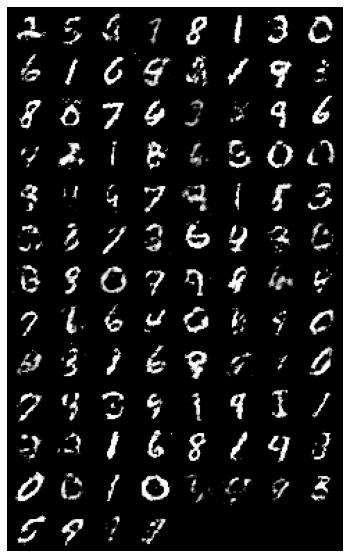

In [18]:
#faked created images
plt.figure(figsize=(12,10))
plt.imshow(np.transpose(img,(1,2,0)))
plt.axis('off')
plt.show()